In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap

#from utils.clim_loss import ClimateDownscalingLoss

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-12-05 09:17:57.602315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

cmip6_psl_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_psl = xr.open_zarr(cmip6_psl_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_psl = cmip6_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

cmip6_data_norm = normalize(cmip6_high_res['tas'])
cmip6_psl_norm = normalize(cmip6_high_psl['psl'])
gmfd_data_norm = normalize(gmfd_data['tas'])


# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
cmip6_train_psl = cmip6_psl_norm.values
gmfd_train = gmfd_data_norm.values

#### Compute residuals

In [3]:
import xarray as xr

# Assuming gmfd_data and cmip6_high_res are xarray Datasets or DataArrays

# 1. Time Alignment: Normalize cmip6_high_res time to date only
cmip6_data_norm['time'] = cmip6_data_norm['time'].dt.floor('D')
residuals = gmfd_data_norm  - cmip6_data_norm

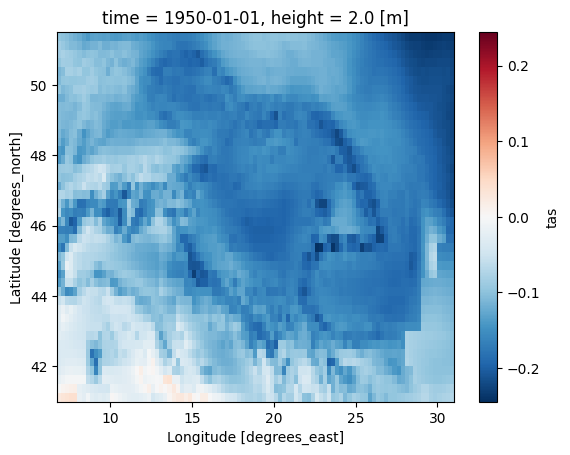

In [4]:
residuals.isel(time=0).plot()

#### Build the resnet (Keras with JAX Backend)


In [5]:
import keras
from keras import ops
from keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add,
    GlobalAveragePooling2D, Dense, Dropout, Reshape,
    Multiply,  # For attention
    LayerNormalization,  # For improved normalization
    GaussianDropout, # For a different kind of regularization
    Concatenate # For skip connections
)
from keras.models import Model
from keras import regularizers  # For regularization
import numpy as np
from keras.optimizers import AdamW #Adam with weight decay
from keras.saving import register_keras_serializable

# Swish Activation Function (Registered)
@register_keras_serializable(package='Custom', name='swish')
def swish(x):
    return x * ops.sigmoid(x)

# Squeeze-and-Excitation (SE) Block for Attention
def se_block(x, reduction_ratio=16):
    filters = ops.shape(x)[-1]
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(se)
    se = Dense(filters, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(se)
    return Multiply()([x, se])

# Enhanced Residual Block with SE Attention and Layer Normalization
def enhanced_residual_block(x, filters, kernel_size=3, stride=1, use_projection=False, dropout_rate=0.05):
    shortcut = x
    if use_projection or stride > 1 or ops.shape(x)[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        shortcut = LayerNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = LayerNormalization()(x)
    x = Activation(swish)(x)
    x = GaussianDropout(dropout_rate)(x) # Add Gaussian Dropout for regularization

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = LayerNormalization()(x)
    x = se_block(x)  # Add Squeeze-and-Excitation block

    x = Add()([shortcut, x])
    return Activation(swish)(x)

# Enhanced ResNet Model
def enhanced_resnet(input_shape, num_residual_blocks, filters, mlp_dim, dropout_rate, attention_stages=None):
    inputs = Input(shape=input_shape)
    x = inputs

    # Initial Conv Layer
    x = Conv2D(filters[0], kernel_size=7, strides=2, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = LayerNormalization()(x)
    x = Activation(swish)(x)

    # Residual Blocks with Attention
    for i, num_blocks in enumerate(num_residual_blocks):
        for j in range(num_blocks):
            stride = 2 if j == 0 and i > 0 else 1  # Downsample at start of each block stack
            use_projection = (j == 0)
            x = enhanced_residual_block(x, filters[i], stride=stride, use_projection=use_projection, dropout_rate=dropout_rate)

            # Optional attention after specific stages
            if attention_stages and i in attention_stages:
              x = se_block(x)

    # Skip connection from the beginning to capture low-level features
    skip = Conv2D(filters[-1], kernel_size=1, strides=2**(len(num_residual_blocks)), padding="same")(inputs)
    skip = LayerNormalization()(skip)

    # Global Average Pooling and Dense Layers
    x = GlobalAveragePooling2D()(x)

    # Concatenate with the skip connection
    x = Concatenate()([x, GlobalAveragePooling2D()(skip)])

    x = Dense(units=mlp_dim, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units=np.prod(input_shape[:-1]), activation="linear", kernel_regularizer=regularizers.l2(1e-4))(x)

    # Reshape to match the desired output shape
    outputs = Reshape(target_shape=input_shape[:-1] + (1,))(x)

    return Model(inputs, outputs)


# Example Usage
# input_shape = (42, 97, 2)  # Temporal/spatial dimensions with 2 channels
# model = enhanced_resnet(
#     input_shape=input_shape,
#     num_residual_blocks=[3, 4, 6, 3],  # Example: ResNet-50 configuration
#     filters=[64, 128, 256, 512],
#     mlp_dim=256,
#     dropout_rate=0.2,
#     attention_stages=[1, 3] # Add attention after the 2nd and 4th residual block stages
# )


# model.summary()



#### Split the data
The historical data were split using as follows: training from 1950-2004, validation from 2004-2009, and testing from 2010-2014.

In [6]:
import pandas as pd
index_2004 = int(np.where(cmip6_data_norm.time.values == pd.to_datetime('2004-12-31'))[0][0])
index_2009 = int(np.where(cmip6_data_norm.time.values == pd.to_datetime('2009-12-31'))[0][0])

In [7]:
# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
cmip6_train_slp_reshaped = cmip6_train_psl[..., np.newaxis]

# Concatenate the reshaped arrays along the last axis
cmip6_train_combined = np.concatenate((cmip6_train_reshaped, cmip6_train_slp_reshaped), axis=-1)

gmfd_train_reshaped = gmfd_train[..., np.newaxis]
residual_reshaped = residuals.values[..., np.newaxis]

# Split the data while preserving the temporal structure
X_train = cmip6_train_combined[:index_2004]
y_train = gmfd_train_reshaped[:index_2004]
res_train = residual_reshaped[:index_2004]

X_val = cmip6_train_combined[index_2004:index_2009]
y_val = gmfd_train_reshaped[index_2004:index_2009]
res_val =  residual_reshaped[index_2004:index_2009]

X_test = cmip6_train_combined[index_2009:]
y_test = gmfd_train_reshaped[index_2009:]
res_test = residual_reshaped[index_2009:]




In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(res_train.shape)
print(res_val.shape)
print(res_test.shape)

(20088, 42, 97, 2)
(1826, 42, 97, 2)
(1827, 42, 97, 2)
(20088, 42, 97, 1)
(1826, 42, 97, 1)
(1827, 42, 97, 1)


#### Create temporal sequences

In [ ]:
def create_sequences(data, target, sequence_length):
    """
    Create sequences of shape (batch, sequence_length, height, width, channels).
    Parameters:
        data (ndarray): Input data of shape (time_steps, height, width, channels).
        target (ndarray): Target data of shape (time_steps, height, width, 1).
        sequence_length (int): Length of each sequence.
    Returns:
        X_seq: Sequences of input data.
        y_seq: Corresponding target data for each sequence.
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(data) - sequence_length):
        X_seq.append(data[i:i + sequence_length])
        y_seq.append(target[i + sequence_length])  # Target is the next time step
    
    return np.array(X_seq), np.array(y_seq)

# Example usage
sequence_length = 1

# Assuming X_train, y_train, X_val, y_val are your original datasets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)





print("X_train_seq shape:", X_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("res_train shape:", res_train_seq.shape)
print("res_val shape:", res_val_seq.shape)


#### Train the model

In [9]:
from keras import ops
from keras.losses import Loss
from keras.saving import register_keras_serializable

@register_keras_serializable()
class ClimateDownscalingLoss(Loss):
    def __init__(self, spatial_weight=1.0, gradient_weight=0.5, **kwargs):
        super().__init__(**kwargs)
        self.spatial_weight = spatial_weight
        self.gradient_weight = gradient_weight

    def call(self, y_true, y_pred):
        # Ensure y_true and y_pred have compatible shapes
        if y_true.shape[-1] != y_pred.shape[-1]:
            raise ValueError(
                f"Mismatch in channel dimensions: y_true has shape {y_true.shape}, y_pred has shape {y_pred.shape}"
            )

        # 1. Mean Squared Error (base loss)
        mse_loss = ops.mean(ops.square(y_true - y_pred))

        # 2. Spatial Gradient Loss
        def spatial_gradients(x):
            """
            Computes spatial gradients along the spatial dimensions (height and width).
            Assumes input shape is (batch, height, width, channels).
            """
            # Gradient along the height (axis 1)
            dy = x[:, 1:, :, :] - x[:, :-1, :, :]
            # Gradient along the width (axis 2)
            dx = x[:, :, 1:, :] - x[:, :, :-1, :]
            return dy, dx

        # Compute spatial gradients for true and predicted values
        true_dy, true_dx = spatial_gradients(y_true)
        pred_dy, pred_dx = spatial_gradients(y_pred)

        # Gradient loss: Mean Squared Error between spatial gradients
        gradient_loss = (
            ops.mean(ops.square(true_dy - pred_dy)) + 
            ops.mean(ops.square(true_dx - pred_dx))
        )

        # Combine MSE loss and gradient loss
        total_loss = (
            self.spatial_weight * mse_loss + 
            self.gradient_weight * gradient_loss
        )
        
        return total_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            "spatial_weight": self.spatial_weight,
            "gradient_weight": self.gradient_weight
        })
        return config

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from keras import ops
from keras.optimizers import AdamW, Adam


# Example Usage
input_shape = (42, 97, 2)  # Temporal/spatial dimensions with 2 channels
model = enhanced_resnet(
    input_shape=input_shape,
    num_residual_blocks=[3, 4, 6, 3],  # Example: ResNet-50 configuration
    filters=[64, 128, 256, 512],
    mlp_dim=256,
    dropout_rate=0.1,
    attention_stages=[1, 3] # Add attention after the 2nd and 4th residual block stages
)


# Training configuration
epochs = 500
batch_size = 100

# Optimizer with learning rate schedule (ReduceLROnPlateau will handle adjustments)
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,  # Starting learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)
# Use AdamW optimizer with weight decay
#optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

# # Create an instance of the loss function
# climate_loss = 'mse'

# # Create an instance of the loss function
climate_loss = ClimateDownscalingLoss(
    spatial_weight=1.0,    # Weight for MSE loss
    gradient_weight=0.5    # Weight for gradient loss
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)


# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='models/resnet_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    keras.callbacks.TerminateOnNaN()
]

# Training
history = model.fit(
    X_train, res_train,
    validation_data=(X_val, res_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,  # Display progress per epoch
    shuffle=False  # Sequential data training
)

# Summarize results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 0.3558 - mean_absolute_error: 0.0646 - root_mean_squared_error: 0.0850
Epoch 1: val_loss improved from inf to 0.01316, saving model to models/resnet_best_model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 161s 528ms/step - loss: 0.3547 - mean_absolute_error: 0.0646 - root_mean_squared_error: 0.0850 - val_loss: 0.0132 - val_mean_absolute_error: 0.0597 - val_root_mean_squared_error: 0.0771 - learning_rate: 0.0010
Epoch 2/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0110 - mean_absolute_error: 0.0596 - root_mean_squared_error: 0.0776
Epoch 2: val_loss improved from 0.01316 to 0.00760, saving model to models/resnet_best_model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 0.0110 - mean_absolute_error: 0.0596 - root_mean_squared_error: 0.0776 - val_loss: 0.0076 - val_mean_absolute_error: 0.0602 - val_root_mean_squared_error: 0.0776 - learning_rate: 0.0010
Epoch 3/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
plt.figure(figsize=(8, 4))

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optional: Set y-axis limits
plt.ylim(0.02, 0.06)

# Show legend
plt.legend()

# Add grid for clarity
plt.grid()

# Show the plot
plt.show()


#### Evaluate the model on validation data

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the model

from keras.models import load_model

model_best = load_model('models/resnet_best_model.keras')

# Get the mean and std from the training set for denormalization
cmip6_high_res_min = cmip6_high_res['tas'].min().values
cmip6_high_res_max = cmip6_high_res['tas'].max().values

# Get the mean and std from the training set for denormalization
gmfd_min = gmfd_data['tas'].min().values
gmfd_max = gmfd_data['tas'].max().values


# Generate predictions on validation data
y_pred = model_best.predict(X_test)
print(y_pred.shape)
print(y_val.shape)
print(y_test.shape)

58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step
(1827, 42, 97, 1)
(1826, 42, 97, 1)
(1827, 42, 97, 1)


In [20]:
y_pred = X_test[:,:,:,0] +  y_pred[:,:,:,0]

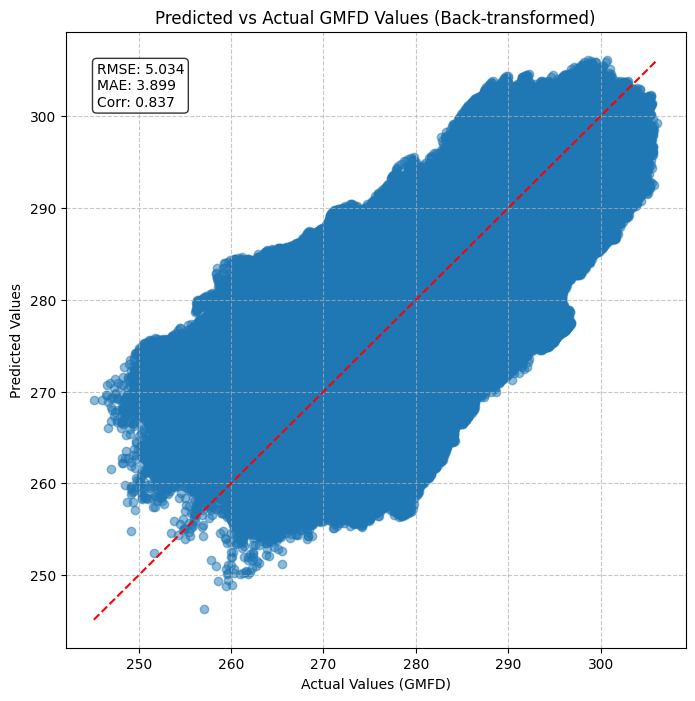

In [21]:
# Back-transform the predictions for evaluation
y_test_denorm = y_test * (gmfd_max - gmfd_min) + gmfd_min
y_pred_denorm = y_pred * (cmip6_high_res_max - cmip6_high_res_min) + cmip6_high_res_min


# Calculate RMSE, MAE, and correlation
rmse = np.sqrt(mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten()))
mae = mean_absolute_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
correlation = np.corrcoef(y_test_denorm.flatten(), y_pred_denorm.flatten())[0,1]

# Create the plot
plt.figure(figsize=(8, 8))
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
plt.scatter(y_test_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_test_denorm.min(), y_test_denorm.max()], 
         [y_test_denorm.min(), y_test_denorm.max()], 'r--')

# Add RMSE, MAE, and correlation text to the upper left
plt.text(0.05, 0.95, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nCorr: {correlation:.3f}',  
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

#### Train the on All Data
Train the model on all the data

In [10]:
X_all = np.concatenate((X_train, X_val, X_test), axis=0)
y_all = np.concatenate((y_train, y_val, y_test), axis=0)
res_all = np.concatenate((res_train, res_val, res_test), axis=0)
X_trainval = np.concatenate((X_train, X_val), axis=0)
y_trainval = np.concatenate((y_train, y_val), axis=0)
res_trainval = np.concatenate((res_train, res_val), axis=0)

In [11]:
# Example Usage
input_shape = (42, 97, 2)  # Temporal/spatial dimensions with 2 channels
model = enhanced_resnet(
    input_shape=input_shape,
    num_residual_blocks=[3, 4, 6, 3],  # Example: ResNet-50 configuration
    filters=[64, 128, 256, 512],
    mlp_dim=256,
    dropout_rate=0.2,
    attention_stages=[1, 3] # Add attention after the 2nd and 4th residual block stages
)


# Training configuration
epochs = 500
batch_size = 100

# Optimizer with learning rate schedule (ReduceLROnPlateau will handle adjustments)
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,  # Starting learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

# Training configuration
epochs = 500
batch_size = 100

#optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

# # Create an instance of the loss function
# climate_loss = 'mse'

# # Create an instance of the loss function
climate_loss = ClimateDownscalingLoss(
    spatial_weight=1.0,    # Weight for MSE loss
    gradient_weight=0.5    # Weight for gradient loss
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='models/resnet_final_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    keras.callbacks.TerminateOnNaN()
]

# Retrain the model using the predefined validation set
history = model.fit(
    X_all, res_all,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    shuffle=False,
    validation_split = 0.2
    #validation_data=(X_val, res_val)
)
# Summarize results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.3610 - mean_absolute_error: 0.0656 - root_mean_squared_error: 0.0864
Epoch 1: val_loss improved from inf to 0.01433, saving model to models/resnet_final_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 162s 559ms/step - loss: 0.3599 - mean_absolute_error: 0.0656 - root_mean_squared_error: 0.0864 - val_loss: 0.0143 - val_mean_absolute_error: 0.0593 - val_root_mean_squared_error: 0.0766 - learning_rate: 0.0010
Epoch 2/500
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0120 - mean_absolute_error: 0.0595 - root_mean_squared_error: 0.0776
Epoch 2: val_loss improved from 0.01433 to 0.00788, saving model to models/resnet_final_model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - loss: 0.0120 - mean_absolute_error: 0.0595 - root_mean_squared_error: 0.0776 - val_loss: 0.0079 - val_mean_absolute_error: 0.0592 - val_root_mean_squared_error: 0.0766 - learning_rate: 0.0010
Epoch 3/500
189/190 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss:

#### Pred on historical data

In [12]:
# Load the model
from keras.models import load_model
model_saved = load_model('models/resnet_final_model.keras')

predicted_high_res = model_saved.predict(X_all)

742/742 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step


In [13]:
print(predicted_high_res[:,0,:,:].shape)
print(cmip6_train_reshaped.shape)

(23741, 97, 1)
(23741, 42, 97, 1)


In [14]:

# Get the mean and std from the training set for denormalization
cmip6_high_res_min = cmip6_high_res['tas'].min().values
cmip6_high_res_max = cmip6_high_res['tas'].max().values

# put back the residuals
predicted_high_res = cmip6_train_reshaped +  predicted_high_res


In [15]:
print(predicted_high_res.shape)

(23741, 42, 97, 1)


In [16]:
#Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_high_res_max- cmip6_high_res_min) +cmip6_high_res_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)
predicted_high_res_final.shape

(23741, 42, 97)

In [17]:
# Inverse transform the predictions to get the actual temperature values


# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_high_res_max- cmip6_high_res_min) +cmip6_high_res_min


# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')


predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/resnet/predicted_high_res_tas_resnet.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


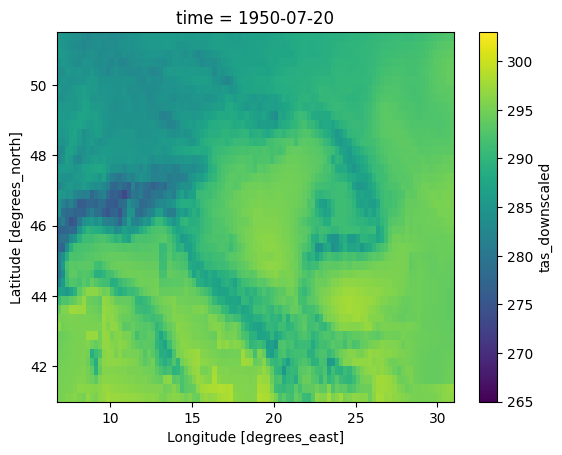

In [18]:
#Select the first time step
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)

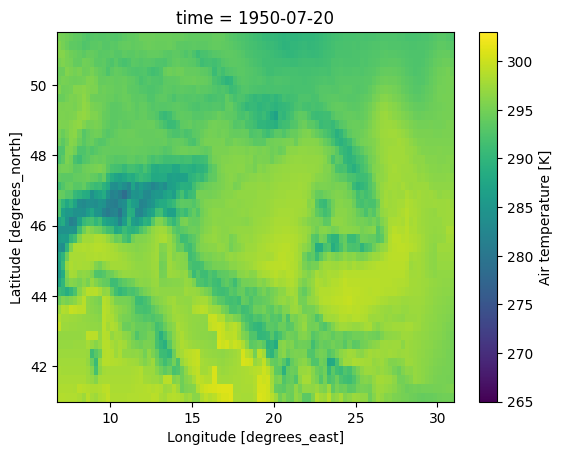

In [19]:
#Select the first time step
first_time_step = gmfd_data.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.tas.plot(vmin=265, vmax=303)

#### Scenario data

In [20]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp245_reshaped_min = cmip6_sp245_high_res['tas'].min().values
cmip6_sp245_reshaped_max = cmip6_sp245_high_res['tas'].max().values
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
cmip6_sp245_norm_reshaped = cmip6_sp245_norm.values[..., np.newaxis]


cmip6_sp245_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_psl = xr.open_zarr(cmip6_sp245_psl)
cmip6_sp245_psl_high_res = cmip6_sp245_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_sp245_psl_norm = normalize(cmip6_sp245_psl_high_res['psl'])
cmip6_sp245_psl_reshaped = cmip6_sp245_psl_norm.values[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp245_norm_reshaped, cmip6_sp245_psl_reshaped), axis=-1)

#### Perform the predictions on scenario data

In [21]:
print(predicted_high_res.shape)
print(cmip6_sp245_norm_reshaped.shape)
# Predict downscaled high-resolution data

(23741, 42, 97, 1)
(31411, 42, 97, 1)


In [22]:

predicted_high_res = model_saved.predict(cmip6_scen_combined)

predicted_high_res = cmip6_sp245_norm_reshaped +  predicted_high_res

# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_sp245_reshaped_max- cmip6_sp245_reshaped_min) + cmip6_sp245_reshaped_min


982/982 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step


In [23]:
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_high_res['tas'].shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='tas_downscaled')

predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/resnet/predicted_high_res_tas_resnet_ssp245.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


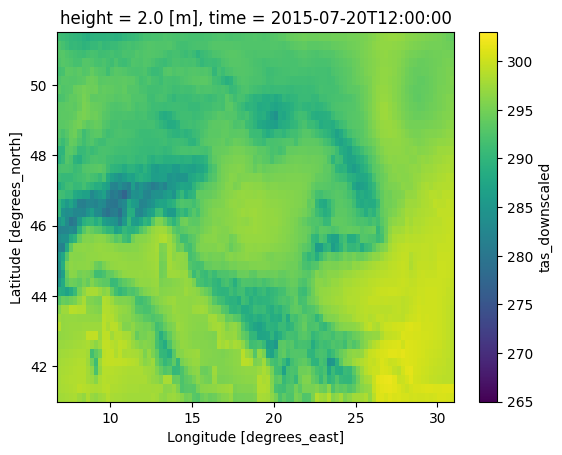

In [24]:
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)

### Scenario data SSP126

In [25]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp126 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp126 = xr.open_zarr(cmip6_ssp126)
cmip6_sp126_high_res = cmip6_ssp126.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp126_reshaped_min = cmip6_sp126_high_res['tas'].min().values
cmip6_sp126_reshaped_max = cmip6_sp126_high_res['tas'].max().values
cmip6_sp126_norm = normalize(cmip6_sp126_high_res['tas'])
cmip6_sp126_norm_reshaped = cmip6_sp126_norm.values[..., np.newaxis]


cmip6_sp126_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_psl = xr.open_zarr(cmip6_sp126_psl)
cmip6_sp126_psl_high_res = cmip6_sp126_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_sp126_psl_norm = normalize(cmip6_sp126_psl_high_res['psl'])
cmip6_sp126_psl_reshaped = cmip6_sp126_psl_norm.values[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp126_norm_reshaped, cmip6_sp126_psl_reshaped), axis=-1)

# Predict downscaled high-resolution data
X_scen = cmip6_scen_combined

predicted_high_res = model_saved.predict(X_scen)

predicted_high_res = cmip6_sp126_norm_reshaped +  predicted_high_res

# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_sp126_reshaped_max- cmip6_sp126_reshaped_min) + cmip6_sp126_reshaped_min

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp126_high_res['tas'].shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='tas_downscaled')

predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/resnet/predicted_high_res_tas_resnet_ssp126.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


982/982 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Downscaled high-resolution predictions saved to NetCDF format.


### Scenario data SSP585

In [26]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp585 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp585 = xr.open_zarr(cmip6_ssp585)
cmip6_sp585_high_res = cmip6_ssp585.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp585_reshaped_min = cmip6_sp585_high_res['tas'].min().values
cmip6_sp585_reshaped_max = cmip6_sp585_high_res['tas'].max().values
cmip6_sp585_norm = normalize(cmip6_sp585_high_res['tas'])
cmip6_sp585_norm_reshaped = cmip6_sp585_norm.values[..., np.newaxis]


cmip6_sp585_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_psl = xr.open_zarr(cmip6_sp585_psl)
cmip6_sp585_psl_high_res = cmip6_sp585_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_sp585_psl_norm = normalize(cmip6_sp585_psl_high_res['psl'])
cmip6_sp585_psl_reshaped = cmip6_sp585_psl_norm.values[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp585_norm_reshaped, cmip6_sp585_psl_reshaped), axis=-1)

# Predict downscaled high-resolution data
X_scen = cmip6_scen_combined

predicted_high_res = model_saved.predict(X_scen)

predicted_high_res = cmip6_sp585_norm_reshaped +  predicted_high_res

# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_sp585_reshaped_max- cmip6_sp585_reshaped_min) + cmip6_sp585_reshaped_min

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp585_high_res['tas'].shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='tas_downscaled')

predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/resnet/predicted_high_res_tas_resnet_ssp585.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


982/982 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Downscaled high-resolution predictions saved to NetCDF format.
